## CIFAR100 Inference Example from OpenAI

Files already downloaded and verified
original label: snake

Top predictions:

snake: 65.38%
turtle: 12.29%
sweet_pepper: 3.81%
lizard: 1.88%
crocodile: 1.74%


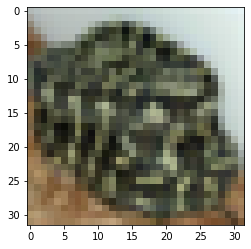

In [1]:
## Example from OpenAI
import os
import clip
import torch
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt 

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[3637]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

plt.imshow(image)
print("original label:", cifar100.classes[class_id])

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]}: {100 * value.item():.2f}%")

## Original ImageNet Inference

In [2]:
import pandas as pd

In [3]:
def make_adverserial_inference_df(inference_path, fgsm = False):
    '''
    Create dataframe for our inference files
    inference_path: path to our inference folder 
    
    returns df with image pointing to image filename and caption to the correct label 
    '''
    file_path_names = os.listdir(inference_path)
    d = {} 
    d['image'] = file_path_names
    labels = []
    captions = []
    for file_path in file_path_names:
        if fgsm:
            name = os.path.splitext(file_path)[0] # remove .JPEG from the end 
            name = ' '.join(name.split('_'))  # "01669191_box_turtle"  to "box turtle"
            label = name
            name = "This is a photo of a " + name  # "box turtle" to "This is box turtle"
        else:
            name = os.path.splitext(file_path)[0] # remove .JPEG from the end 
            name = ' '.join(name.split('_')[1:])  # "01669191_box_turtle"  to "box turtle"
            label = name
            name = "This is a photo of a " + name  # "box turtle" to "This is box turtle"
        captions.append(name)
        labels.append(label)
    d['caption'] = captions 
    d['label'] = labels
    df = pd.DataFrame(data=d)
    
    return df 

In [4]:
def find_match(image_input, text_inputs, model, classes, k=5, print_only=False):
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(k)
    if print_only:
        for value, index in zip(values, indices):
            print(f"{classes[index]:>16s}: {100 * value.item():.2f}%")
    matches = [classes[index] for index in indices]
    return matches 

In [5]:
from tqdm import tqdm
from PIL import Image
def top_k_inf(model, df, k=5, attack_mode=None):
    
    # appending the correct folder path
    if attack_mode is None:
        source_path = "data/originalImagenet/"
    elif attack_mode == "pgd":
        source_path = "data/pgdAttack/"
    elif attack_mode == "fgsm":
        source_path = "data/fgsmAttack/"
    correct = 0
    
    text_inputs = df['caption'].values
    text_inputs = torch.cat([clip.tokenize(c) for c in text_inputs]).to(device)

    for index,row in tqdm(df.iterrows(), total=len(df)): 
        image_path = source_path + row['image']
        image = Image.open(image_path).convert('RGB')
        image_input = preprocess(image).unsqueeze(0).to(device)

        matches = find_match(image_input, text_inputs, model, df['caption'].values, k,  False)

        for match in matches:
            if row['label'] in match: 
                correct += 1
        if index % 100 == 0:
            print(f"Correct raw: {correct}, Percent: {round(correct/(index+1) *100, 2)}")

    print(f"Attack mode is {attack_mode}")
    print(f"# of correct predictions: {correct}")
    print(f"Top-{k} Accuracy: {round(correct/len(df)* 100, 2)}")

In [6]:
# No attack - originalImagnet dataset 
model, preprocess = clip.load('ViT-B/32', device)
og_df = make_adverserial_inference_df("data/originalImagenet")

In [7]:
og_df = og_df.drop(og_df[og_df.image == '.git'].index)

In [8]:
og_df

,image,caption,label
0,n02002556_white_stork.JPEG,This is a photo of a white stork,white stork
1,n02974003_car_wheel.JPEG,This is a photo of a car wheel,car wheel
2,n03759954_microphone.JPEG,This is a photo of a microphone,microphone
3,n04141327_scabbard.JPEG,This is a photo of a scabbard,scabbard
4,n03461385_grocery_store.JPEG,This is a photo of a grocery store,grocery store
...,...,...,...
996,n04023962_punching_bag.JPEG,This is a photo of a punching bag,punching bag
997,n02930766_cab.JPEG,This is a photo of a cab,cab
998,n03180011_desktop_computer.JPEG,This is a photo of a desktop computer,desktop computer
999,n03770439_miniskirt.JPEG,This is a photo of a miniskirt,miniskirt


In [51]:
top_k_inf(model, og_df, k=5)

  0%|                                                     | 1/1000 [00:00<15:05,  1.10it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:34<13:50,  1.08it/s]

Correct raw: 96, Percent: 95.05


 20%|██████████▏                                        | 200/1000 [03:06<12:21,  1.08it/s]

Correct raw: 175, Percent: 87.06


 30%|███████████████▎                                   | 300/1000 [04:39<10:52,  1.07it/s]

Correct raw: 269, Percent: 89.37


 40%|████████████████████▍                              | 400/1000 [06:12<09:14,  1.08it/s]

Correct raw: 353, Percent: 88.03


 50%|█████████████████████████▌                         | 500/1000 [07:45<07:45,  1.07it/s]

Correct raw: 441, Percent: 88.02


 60%|██████████████████████████████▌                    | 600/1000 [09:18<06:11,  1.08it/s]

Correct raw: 528, Percent: 87.85


 70%|███████████████████████████████████▋               | 700/1000 [10:51<04:38,  1.08it/s]

Correct raw: 615, Percent: 87.73


 80%|████████████████████████████████████████▊          | 800/1000 [12:24<03:05,  1.08it/s]

Correct raw: 702, Percent: 87.64


 90%|█████████████████████████████████████████████▉     | 900/1000 [13:58<01:33,  1.07it/s]

Correct raw: 783, Percent: 86.9


100%|██████████████████████████████████████████████████| 1000/1000 [15:31<00:00,  1.07it/s]

Correct raw: 872, Percent: 87.11
Attack mode is None
# of correct predictions: 872
Top-5 Accuracy: 87.2


## PGD Attack ImageNet Inference

In [8]:
pgd_df = make_adverserial_inference_df("data/pgdAttack")

In [10]:
pgd_df

,image,caption,label
0,n02002556_white_stork.JPEG,This is a photo of a white stork,white stork
1,n02974003_car_wheel.JPEG,This is a photo of a car wheel,car wheel
2,n03759954_microphone.JPEG,This is a photo of a microphone,microphone
3,n04141327_scabbard.JPEG,This is a photo of a scabbard,scabbard
4,n03461385_grocery_store.JPEG,This is a photo of a grocery store,grocery store
...,...,...,...
995,n04023962_punching_bag.JPEG,This is a photo of a punching bag,punching bag
996,n02930766_cab.JPEG,This is a photo of a cab,cab
997,n03180011_desktop_computer.JPEG,This is a photo of a desktop computer,desktop computer
998,n03770439_miniskirt.JPEG,This is a photo of a miniskirt,miniskirt


In [52]:
top_k_inf(model, pgd_df, k=5, attack_mode='pgd')

  0%|                                                     | 1/1000 [00:00<15:32,  1.07it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:34<14:01,  1.07it/s]

Correct raw: 70, Percent: 69.31


 20%|██████████▎                                        | 201/1000 [03:07<12:24,  1.07it/s]

Correct raw: 127, Percent: 63.18


 30%|███████████████▎                                   | 301/1000 [04:41<10:57,  1.06it/s]

Correct raw: 198, Percent: 65.78


 40%|████████████████████▍                              | 401/1000 [06:15<09:20,  1.07it/s]

Correct raw: 262, Percent: 65.34


 50%|█████████████████████████▌                         | 501/1000 [07:48<07:46,  1.07it/s]

Correct raw: 321, Percent: 64.07


 60%|██████████████████████████████▋                    | 601/1000 [09:22<06:14,  1.06it/s]

Correct raw: 374, Percent: 62.23


 70%|███████████████████████████████████▊               | 701/1000 [10:55<04:38,  1.07it/s]

Correct raw: 430, Percent: 61.34


 80%|████████████████████████████████████████▊          | 801/1000 [12:29<03:06,  1.07it/s]

Correct raw: 496, Percent: 61.92


 90%|█████████████████████████████████████████████▉     | 901/1000 [14:02<01:32,  1.07it/s]

Correct raw: 550, Percent: 61.04


100%|██████████████████████████████████████████████████| 1000/1000 [15:34<00:00,  1.07it/s]

Attack mode is pgd
# of correct predictions: 622
Top-5 Accuracy: 62.2


## FGSM Attack ImageNet Inference

In [9]:
fgsm_df = make_adverserial_inference_df("data/fgsmAttack", fgsm=True)

In [12]:
fgsm_df

,image,caption,label
0,bassoon.JPEG,This is a photo of a bassoon,bassoon
1,Siamese_cat.JPEG,This is a photo of a Siamese cat,Siamese cat
2,French_bulldog.JPEG,This is a photo of a French bulldog,French bulldog
3,paintbrush.JPEG,This is a photo of a paintbrush,paintbrush
4,cliff_dwelling.JPEG,This is a photo of a cliff dwelling,cliff dwelling
...,...,...,...
992,fly.JPEG,This is a photo of a fly,fly
993,West_Highland_white_terrier.JPEG,This is a photo of a West Highland white terrier,West Highland white terrier
994,Windsor_tie.JPEG,This is a photo of a Windsor tie,Windsor tie
995,catamaran.JPEG,This is a photo of a catamaran,catamaran


In [53]:
top_k_inf(model, fgsm_df, k=5, attack_mode='fgsm')

  0%|                                                      | 1/997 [00:00<14:56,  1.11it/s]

Correct raw: 0, Percent: 0.0


 10%|█████▎                                              | 101/997 [01:33<13:47,  1.08it/s]

Correct raw: 54, Percent: 53.47


 20%|██████████▍                                         | 201/997 [03:05<12:13,  1.08it/s]

Correct raw: 100, Percent: 49.75


 30%|███████████████▋                                    | 301/997 [04:37<10:39,  1.09it/s]

Correct raw: 143, Percent: 47.51


 40%|████████████████████▉                               | 401/997 [06:09<09:09,  1.09it/s]

Correct raw: 187, Percent: 46.63


 50%|██████████████████████████▏                         | 501/997 [07:40<07:31,  1.10it/s]

Correct raw: 238, Percent: 47.5


 60%|███████████████████████████████▎                    | 601/997 [09:11<06:01,  1.10it/s]

Correct raw: 280, Percent: 46.59


 70%|████████████████████████████████████▌               | 701/997 [10:43<04:30,  1.09it/s]

Correct raw: 326, Percent: 46.5


 80%|█████████████████████████████████████████▊          | 801/997 [12:14<02:57,  1.10it/s]

Correct raw: 370, Percent: 46.19


 90%|██████████████████████████████████████████████▉     | 901/997 [13:45<01:27,  1.10it/s]

Correct raw: 414, Percent: 45.95


100%|████████████████████████████████████████████████████| 997/997 [15:13<00:00,  1.09it/s]

Attack mode is fgsm
# of correct predictions: 460
Top-5 Accuracy: 46.14


# Experiments to Improve Robustness

## 1-  Inference on Gaussian Noise Imagenet

In [28]:
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
models = ["Gaussian_0.4_3_best.pt", "Gaussian_0.6_3_best.pt", "Gaussian_0.8_3_best.pt", "Gaussian_1_3_best.pt"]


for m in models: 
    checkpoint = torch.load(m)
    model.load_state_dict(checkpoint)
    
    top_k_inf(model, og_df, k=5)
    
    top_k_inf(model, pgd_df, k=5, attack_mode='pgd')
    
    top_k_inf(model, fgsm_df, k=5, attack_mode='fgsm')

  0%|                                                     | 1/1000 [00:00<15:29,  1.07it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:34<13:46,  1.09it/s]

Correct raw: 100, Percent: 99.01


 20%|██████████▏                                        | 200/1000 [03:07<12:27,  1.07it/s]

Correct raw: 199, Percent: 99.0


 30%|███████████████▎                                   | 300/1000 [04:40<10:48,  1.08it/s]

Correct raw: 298, Percent: 99.0


 40%|████████████████████▍                              | 400/1000 [06:13<09:17,  1.08it/s]

Correct raw: 396, Percent: 98.75


 50%|█████████████████████████▌                         | 500/1000 [07:46<07:45,  1.08it/s]

Correct raw: 500, Percent: 99.8


 60%|██████████████████████████████▌                    | 600/1000 [09:19<06:12,  1.07it/s]

Correct raw: 597, Percent: 99.33


 70%|███████████████████████████████████▋               | 700/1000 [10:52<04:37,  1.08it/s]

Correct raw: 693, Percent: 98.86


 80%|████████████████████████████████████████▊          | 800/1000 [12:25<03:05,  1.08it/s]

Correct raw: 785, Percent: 98.0


 90%|█████████████████████████████████████████████▉     | 900/1000 [13:58<01:33,  1.07it/s]

Correct raw: 877, Percent: 97.34


100%|██████████████████████████████████████████████████| 1000/1000 [15:31<00:00,  1.07it/s]


Correct raw: 976, Percent: 97.5
Attack mode is None
# of correct predictions: 976
Top-5 Accuracy: 97.6


  0%|                                                     | 1/1000 [00:00<14:41,  1.13it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:33<14:00,  1.07it/s]

Correct raw: 50, Percent: 49.5


 20%|██████████▎                                        | 201/1000 [03:07<12:28,  1.07it/s]

Correct raw: 98, Percent: 48.76


 30%|███████████████▎                                   | 301/1000 [04:41<10:55,  1.07it/s]

Correct raw: 145, Percent: 48.17


 40%|████████████████████▍                              | 401/1000 [06:14<09:16,  1.08it/s]

Correct raw: 200, Percent: 49.88


 50%|█████████████████████████▌                         | 501/1000 [07:47<07:42,  1.08it/s]

Correct raw: 245, Percent: 48.9


 60%|██████████████████████████████▋                    | 601/1000 [09:20<06:11,  1.07it/s]

Correct raw: 277, Percent: 46.09


 70%|███████████████████████████████████▊               | 701/1000 [10:53<04:37,  1.08it/s]

Correct raw: 321, Percent: 45.79


 80%|████████████████████████████████████████▊          | 801/1000 [12:26<03:05,  1.07it/s]

Correct raw: 373, Percent: 46.57


 90%|█████████████████████████████████████████████▉     | 901/1000 [13:59<01:32,  1.07it/s]

Correct raw: 417, Percent: 46.28


100%|██████████████████████████████████████████████████| 1000/1000 [15:32<00:00,  1.07it/s]


Attack mode is pgd
# of correct predictions: 462
Top-5 Accuracy: 46.2


  0%|                                                      | 1/997 [00:00<14:23,  1.15it/s]

Correct raw: 0, Percent: 0.0


 10%|█████▎                                              | 101/997 [01:33<13:46,  1.08it/s]

Correct raw: 39, Percent: 38.61


 20%|██████████▍                                         | 201/997 [03:05<12:10,  1.09it/s]

Correct raw: 90, Percent: 44.78


 30%|███████████████▋                                    | 301/997 [04:36<10:38,  1.09it/s]

Correct raw: 141, Percent: 46.84


 40%|████████████████████▉                               | 401/997 [06:08<09:07,  1.09it/s]

Correct raw: 199, Percent: 49.63


 50%|██████████████████████████▏                         | 501/997 [07:40<07:35,  1.09it/s]

Correct raw: 241, Percent: 48.1


 60%|███████████████████████████████▎                    | 601/997 [09:12<06:02,  1.09it/s]

Correct raw: 280, Percent: 46.59


 70%|████████████████████████████████████▌               | 701/997 [10:44<04:31,  1.09it/s]

Correct raw: 321, Percent: 45.79


 80%|█████████████████████████████████████████▊          | 801/997 [12:16<02:59,  1.09it/s]

Correct raw: 361, Percent: 45.07


 90%|██████████████████████████████████████████████▉     | 901/997 [13:47<01:27,  1.10it/s]

Correct raw: 400, Percent: 44.4


100%|████████████████████████████████████████████████████| 997/997 [15:16<00:00,  1.09it/s]


Attack mode is fgsm
# of correct predictions: 445
Top-5 Accuracy: 44.63


  0%|                                                     | 1/1000 [00:00<15:49,  1.05it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:34<14:04,  1.07it/s]

Correct raw: 99, Percent: 98.02


 20%|██████████▏                                        | 200/1000 [03:06<12:29,  1.07it/s]

Correct raw: 199, Percent: 99.0


 30%|███████████████▎                                   | 300/1000 [04:39<10:56,  1.07it/s]

Correct raw: 301, Percent: 100.0


 40%|████████████████████▍                              | 400/1000 [06:12<09:20,  1.07it/s]

Correct raw: 399, Percent: 99.5


 50%|█████████████████████████▌                         | 500/1000 [07:46<07:46,  1.07it/s]

Correct raw: 502, Percent: 100.2


 60%|██████████████████████████████▌                    | 600/1000 [09:19<06:12,  1.07it/s]

Correct raw: 601, Percent: 100.0


 70%|███████████████████████████████████▋               | 700/1000 [10:52<04:39,  1.07it/s]

Correct raw: 696, Percent: 99.29


 80%|████████████████████████████████████████▊          | 800/1000 [12:26<03:06,  1.08it/s]

Correct raw: 792, Percent: 98.88


 90%|█████████████████████████████████████████████▉     | 900/1000 [13:59<01:33,  1.07it/s]

Correct raw: 890, Percent: 98.78


100%|██████████████████████████████████████████████████| 1000/1000 [15:32<00:00,  1.07it/s]


Correct raw: 993, Percent: 99.2
Attack mode is None
# of correct predictions: 993
Top-5 Accuracy: 99.3


  0%|                                                     | 1/1000 [00:00<15:25,  1.08it/s]

Correct raw: 0, Percent: 0.0


 10%|█████▏                                             | 101/1000 [01:34<13:57,  1.07it/s]

Correct raw: 58, Percent: 57.43


 20%|██████████▎                                        | 201/1000 [03:07<12:24,  1.07it/s]

Correct raw: 118, Percent: 58.71


 30%|███████████████▎                                   | 301/1000 [04:40<10:50,  1.07it/s]

Correct raw: 183, Percent: 60.8


 40%|████████████████████▍                              | 401/1000 [06:13<09:19,  1.07it/s]

Correct raw: 242, Percent: 60.35


 50%|█████████████████████████▌                         | 501/1000 [07:47<07:44,  1.07it/s]

Correct raw: 301, Percent: 60.08


 60%|██████████████████████████████▋                    | 601/1000 [09:20<06:10,  1.08it/s]

Correct raw: 349, Percent: 58.07


 70%|███████████████████████████████████▊               | 701/1000 [10:52<04:38,  1.07it/s]

Correct raw: 409, Percent: 58.35


 80%|████████████████████████████████████████▊          | 801/1000 [12:26<03:05,  1.07it/s]

Correct raw: 465, Percent: 58.05


 90%|█████████████████████████████████████████████▉     | 901/1000 [14:00<01:32,  1.07it/s]

Correct raw: 522, Percent: 57.94


100%|██████████████████████████████████████████████████| 1000/1000 [15:32<00:00,  1.07it/s]


Attack mode is pgd
# of correct predictions: 573
Top-5 Accuracy: 57.3


  0%|                                                      | 1/997 [00:00<15:23,  1.08it/s]

Correct raw: 0, Percent: 0.0


 10%|█████▎                                              | 101/997 [01:32<13:43,  1.09it/s]

Correct raw: 61, Percent: 60.4


 20%|██████████▍                                         | 201/997 [03:04<12:09,  1.09it/s]

Correct raw: 120, Percent: 59.7


 30%|███████████████▋                                    | 301/997 [04:36<10:40,  1.09it/s]

Correct raw: 177, Percent: 58.8


 40%|████████████████████▉                               | 401/997 [06:08<09:07,  1.09it/s]

Correct raw: 233, Percent: 58.1


 50%|██████████████████████████▏                         | 501/997 [07:40<07:36,  1.09it/s]

Correct raw: 284, Percent: 56.69


 60%|███████████████████████████████▎                    | 601/997 [09:12<06:05,  1.08it/s]

Correct raw: 338, Percent: 56.24


 70%|████████████████████████████████████▌               | 701/997 [10:44<04:32,  1.09it/s]

Correct raw: 392, Percent: 55.92


 80%|█████████████████████████████████████████▊          | 801/997 [12:16<03:01,  1.08it/s]

Correct raw: 455, Percent: 56.8


 90%|██████████████████████████████████████████████▉     | 901/997 [13:48<01:28,  1.08it/s]

Correct raw: 513, Percent: 56.94


100%|████████████████████████████████████████████████████| 997/997 [15:17<00:00,  1.09it/s]


Attack mode is fgsm
# of correct predictions: 577
Top-5 Accuracy: 57.87


  0%|                                                     | 1/1000 [00:00<15:48,  1.05it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:34<14:05,  1.06it/s]

Correct raw: 99, Percent: 98.02


 20%|██████████▏                                        | 200/1000 [03:06<12:26,  1.07it/s]

Correct raw: 198, Percent: 98.51


 30%|███████████████▎                                   | 300/1000 [04:39<10:48,  1.08it/s]

Correct raw: 298, Percent: 99.0


 40%|████████████████████▍                              | 400/1000 [06:12<09:18,  1.07it/s]

Correct raw: 398, Percent: 99.25


 50%|█████████████████████████▌                         | 500/1000 [07:46<07:44,  1.08it/s]

Correct raw: 503, Percent: 100.4


 60%|██████████████████████████████▌                    | 600/1000 [09:19<06:12,  1.07it/s]

Correct raw: 603, Percent: 100.33


 70%|███████████████████████████████████▋               | 700/1000 [10:52<04:38,  1.08it/s]

Correct raw: 701, Percent: 100.0


 80%|████████████████████████████████████████▊          | 800/1000 [12:25<03:05,  1.08it/s]

Correct raw: 801, Percent: 100.0


 90%|█████████████████████████████████████████████▉     | 900/1000 [13:58<01:32,  1.08it/s]

Correct raw: 898, Percent: 99.67


100%|██████████████████████████████████████████████████| 1000/1000 [15:31<00:00,  1.07it/s]


Correct raw: 1001, Percent: 100.0
Attack mode is None
# of correct predictions: 1001
Top-5 Accuracy: 100.1


  0%|                                                     | 1/1000 [00:00<15:48,  1.05it/s]

Correct raw: 0, Percent: 0.0


 10%|█████▏                                             | 101/1000 [01:34<14:02,  1.07it/s]

Correct raw: 45, Percent: 44.55


 20%|██████████▎                                        | 201/1000 [03:08<12:30,  1.06it/s]

Correct raw: 90, Percent: 44.78


 30%|███████████████▎                                   | 301/1000 [04:41<10:52,  1.07it/s]

Correct raw: 137, Percent: 45.51


 40%|████████████████████▍                              | 401/1000 [06:15<09:22,  1.06it/s]

Correct raw: 193, Percent: 48.13


 50%|█████████████████████████▌                         | 501/1000 [07:48<07:47,  1.07it/s]

Correct raw: 243, Percent: 48.5


 60%|██████████████████████████████▋                    | 601/1000 [09:22<06:12,  1.07it/s]

Correct raw: 281, Percent: 46.76


 70%|███████████████████████████████████▊               | 701/1000 [10:56<04:40,  1.07it/s]

Correct raw: 330, Percent: 47.08


 80%|████████████████████████████████████████▊          | 801/1000 [12:29<03:05,  1.08it/s]

Correct raw: 386, Percent: 48.19


 90%|█████████████████████████████████████████████▉     | 901/1000 [14:02<01:32,  1.07it/s]

Correct raw: 437, Percent: 48.5


100%|██████████████████████████████████████████████████| 1000/1000 [15:35<00:00,  1.07it/s]


Attack mode is pgd
# of correct predictions: 489
Top-5 Accuracy: 48.9


  0%|                                                      | 1/997 [00:00<14:22,  1.15it/s]

Correct raw: 0, Percent: 0.0


 10%|█████▎                                              | 101/997 [01:32<13:43,  1.09it/s]

Correct raw: 46, Percent: 45.54


 20%|██████████▍                                         | 201/997 [03:04<12:05,  1.10it/s]

Correct raw: 101, Percent: 50.25


 30%|███████████████▋                                    | 301/997 [04:35<10:35,  1.09it/s]

Correct raw: 159, Percent: 52.82


 40%|████████████████████▉                               | 401/997 [06:07<09:06,  1.09it/s]

Correct raw: 208, Percent: 51.87


 50%|██████████████████████████▏                         | 501/997 [07:39<07:34,  1.09it/s]

Correct raw: 264, Percent: 52.69


 60%|███████████████████████████████▎                    | 601/997 [09:10<06:02,  1.09it/s]

Correct raw: 317, Percent: 52.75


 70%|████████████████████████████████████▌               | 701/997 [10:42<04:29,  1.10it/s]

Correct raw: 361, Percent: 51.5


 80%|█████████████████████████████████████████▊          | 801/997 [12:13<02:59,  1.09it/s]

Correct raw: 409, Percent: 51.06


 90%|██████████████████████████████████████████████▉     | 901/997 [13:45<01:28,  1.09it/s]

Correct raw: 470, Percent: 52.16


100%|████████████████████████████████████████████████████| 997/997 [15:13<00:00,  1.09it/s]


Attack mode is fgsm
# of correct predictions: 523
Top-5 Accuracy: 52.46


  0%|                                                     | 1/1000 [00:00<15:14,  1.09it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:34<14:06,  1.06it/s]

Correct raw: 100, Percent: 99.01


 20%|██████████▏                                        | 200/1000 [03:06<12:29,  1.07it/s]

Correct raw: 199, Percent: 99.0


 30%|███████████████▎                                   | 300/1000 [04:39<10:49,  1.08it/s]

Correct raw: 296, Percent: 98.34


 40%|████████████████████▍                              | 400/1000 [06:12<09:20,  1.07it/s]

Correct raw: 399, Percent: 99.5


 50%|█████████████████████████▌                         | 500/1000 [07:45<07:43,  1.08it/s]

Correct raw: 505, Percent: 100.8


 60%|██████████████████████████████▌                    | 600/1000 [09:18<06:11,  1.08it/s]

Correct raw: 604, Percent: 100.5


 70%|███████████████████████████████████▋               | 700/1000 [10:51<04:38,  1.08it/s]

Correct raw: 703, Percent: 100.29


 80%|████████████████████████████████████████▊          | 800/1000 [12:25<03:06,  1.07it/s]

Correct raw: 802, Percent: 100.12


 90%|█████████████████████████████████████████████▉     | 900/1000 [13:58<01:33,  1.07it/s]

Correct raw: 898, Percent: 99.67


100%|██████████████████████████████████████████████████| 1000/1000 [15:31<00:00,  1.07it/s]


Correct raw: 1001, Percent: 100.0
Attack mode is None
# of correct predictions: 1001
Top-5 Accuracy: 100.1


  0%|                                                     | 1/1000 [00:00<15:35,  1.07it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:34<14:02,  1.07it/s]

Correct raw: 53, Percent: 52.48


 20%|██████████▎                                        | 201/1000 [03:07<12:28,  1.07it/s]

Correct raw: 103, Percent: 51.24


 30%|███████████████▎                                   | 301/1000 [04:41<10:52,  1.07it/s]

Correct raw: 161, Percent: 53.49


 40%|████████████████████▍                              | 401/1000 [06:15<09:21,  1.07it/s]

Correct raw: 217, Percent: 54.11


 50%|█████████████████████████▌                         | 501/1000 [07:48<07:44,  1.07it/s]

Correct raw: 278, Percent: 55.49


 60%|██████████████████████████████▋                    | 601/1000 [09:21<06:13,  1.07it/s]

Correct raw: 315, Percent: 52.41


 70%|███████████████████████████████████▊               | 701/1000 [10:54<04:37,  1.08it/s]

Correct raw: 364, Percent: 51.93


 80%|████████████████████████████████████████▊          | 801/1000 [12:27<03:04,  1.08it/s]

Correct raw: 411, Percent: 51.31


 90%|█████████████████████████████████████████████▉     | 901/1000 [14:00<01:32,  1.07it/s]

Correct raw: 468, Percent: 51.94


100%|██████████████████████████████████████████████████| 1000/1000 [15:33<00:00,  1.07it/s]


Attack mode is pgd
# of correct predictions: 527
Top-5 Accuracy: 52.7


  0%|                                                      | 1/997 [00:00<14:26,  1.15it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▎                                              | 101/997 [01:32<13:45,  1.09it/s]

Correct raw: 52, Percent: 51.49


 20%|██████████▍                                         | 201/997 [03:04<12:08,  1.09it/s]

Correct raw: 106, Percent: 52.74


 30%|███████████████▋                                    | 301/997 [04:36<10:33,  1.10it/s]

Correct raw: 160, Percent: 53.16


 40%|████████████████████▉                               | 401/997 [06:07<09:01,  1.10it/s]

Correct raw: 213, Percent: 53.12


 50%|██████████████████████████▏                         | 501/997 [07:38<07:37,  1.08it/s]

Correct raw: 279, Percent: 55.69


 60%|███████████████████████████████▎                    | 601/997 [09:11<06:04,  1.09it/s]

Correct raw: 332, Percent: 55.24


 70%|████████████████████████████████████▌               | 701/997 [10:43<04:32,  1.09it/s]

Correct raw: 398, Percent: 56.78


 80%|█████████████████████████████████████████▊          | 801/997 [12:15<03:00,  1.09it/s]

Correct raw: 454, Percent: 56.68


 90%|██████████████████████████████████████████████▉     | 901/997 [13:47<01:28,  1.08it/s]

Correct raw: 511, Percent: 56.71


100%|████████████████████████████████████████████████████| 997/997 [15:15<00:00,  1.09it/s]

Attack mode is fgsm
# of correct predictions: 565
Top-5 Accuracy: 56.67


* **Inference Accuracy**

    
| Gaussian Noise  | Original Dataset |  PGD Dataset |  FGSM Dataset |
|   -----------   |   -----------   |   ----------- |    ----------- |
|   0   |   87.11   |   62.2 |    46.14 |
|  0.4      | 97.6       |    46.2       |    44.63       |
| 0.6   | 99.3        |   57.3       |    57.87       |
| 0.8   | 100     |   48.9       |    52.46       |
| 1.0   | 100   |   52.7       |    56.67       |

## 2- Inference on Adversarially Trained Model

In [13]:
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
models = ["adv_trained_pgd_best2.pt", "adv_trained_fgsm_best2.pt"]


for m in models: 
    checkpoint = torch.load(m)
    model.load_state_dict(checkpoint)
    
    #top_k_inf(model, og_df, k=5)
    
    top_k_inf(model, pgd_df, k=5, attack_mode='pgd')
    
    top_k_inf(model, fgsm_df, k=5, attack_mode='fgsm')

  0%|                                                     | 1/1000 [00:00<14:59,  1.11it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:33<13:29,  1.11it/s]

Correct raw: 21, Percent: 20.79


 20%|██████████▎                                        | 201/1000 [03:06<12:10,  1.09it/s]

Correct raw: 40, Percent: 19.9


 30%|███████████████▎                                   | 301/1000 [04:38<10:46,  1.08it/s]

Correct raw: 56, Percent: 18.6


 40%|████████████████████▍                              | 401/1000 [06:10<09:12,  1.08it/s]

Correct raw: 80, Percent: 19.95


 50%|█████████████████████████▌                         | 501/1000 [07:42<07:41,  1.08it/s]

Correct raw: 101, Percent: 20.16


 60%|██████████████████████████████▋                    | 601/1000 [09:15<06:07,  1.09it/s]

Correct raw: 116, Percent: 19.3


 70%|███████████████████████████████████▊               | 701/1000 [10:47<04:35,  1.09it/s]

Correct raw: 132, Percent: 18.83


 80%|████████████████████████████████████████▊          | 801/1000 [12:19<03:03,  1.08it/s]

Correct raw: 152, Percent: 18.98


 90%|█████████████████████████████████████████████▉     | 901/1000 [13:52<01:31,  1.08it/s]

Correct raw: 175, Percent: 19.42


100%|██████████████████████████████████████████████████| 1000/1000 [15:23<00:00,  1.08it/s]


Attack mode is pgd
# of correct predictions: 192
Top-5 Accuracy: 19.2


  0%|                                                      | 1/997 [00:00<14:13,  1.17it/s]

Correct raw: 0, Percent: 0.0


 10%|█████▎                                              | 101/997 [01:31<13:33,  1.10it/s]

Correct raw: 14, Percent: 13.86


 20%|██████████▍                                         | 201/997 [03:02<11:59,  1.11it/s]

Correct raw: 25, Percent: 12.44


 30%|███████████████▋                                    | 301/997 [04:32<10:29,  1.11it/s]

Correct raw: 33, Percent: 10.96


 40%|████████████████████▉                               | 401/997 [06:03<09:00,  1.10it/s]

Correct raw: 48, Percent: 11.97


 50%|██████████████████████████▏                         | 501/997 [07:33<07:31,  1.10it/s]

Correct raw: 70, Percent: 13.97


 60%|███████████████████████████████▎                    | 601/997 [09:04<05:58,  1.10it/s]

Correct raw: 76, Percent: 12.65


 70%|████████████████████████████████████▌               | 701/997 [10:35<04:27,  1.11it/s]

Correct raw: 91, Percent: 12.98


 80%|█████████████████████████████████████████▊          | 801/997 [12:06<02:57,  1.10it/s]

Correct raw: 94, Percent: 11.74


 90%|██████████████████████████████████████████████▉     | 901/997 [13:36<01:27,  1.10it/s]

Correct raw: 106, Percent: 11.76


100%|████████████████████████████████████████████████████| 997/997 [15:04<00:00,  1.10it/s]


Attack mode is fgsm
# of correct predictions: 115
Top-5 Accuracy: 11.53


  0%|                                                     | 1/1000 [00:00<15:22,  1.08it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:33<13:50,  1.08it/s]

Correct raw: 29, Percent: 28.71


 20%|██████████▎                                        | 201/1000 [03:05<12:18,  1.08it/s]

Correct raw: 41, Percent: 20.4


 30%|███████████████▎                                   | 301/1000 [04:38<10:49,  1.08it/s]

Correct raw: 66, Percent: 21.93


 40%|████████████████████▍                              | 401/1000 [06:11<09:16,  1.08it/s]

Correct raw: 93, Percent: 23.19


 50%|█████████████████████████▌                         | 501/1000 [07:44<07:44,  1.08it/s]

Correct raw: 115, Percent: 22.95


 60%|██████████████████████████████▋                    | 601/1000 [09:17<06:09,  1.08it/s]

Correct raw: 130, Percent: 21.63


 70%|███████████████████████████████████▊               | 701/1000 [10:49<04:37,  1.08it/s]

Correct raw: 149, Percent: 21.26


 80%|████████████████████████████████████████▊          | 801/1000 [12:22<03:04,  1.08it/s]

Correct raw: 169, Percent: 21.1


 90%|█████████████████████████████████████████████▉     | 901/1000 [13:55<01:31,  1.08it/s]

Correct raw: 185, Percent: 20.53


100%|██████████████████████████████████████████████████| 1000/1000 [15:26<00:00,  1.08it/s]


Attack mode is pgd
# of correct predictions: 203
Top-5 Accuracy: 20.3


  0%|                                                      | 1/997 [00:00<14:57,  1.11it/s]

Correct raw: 0, Percent: 0.0


 10%|█████▎                                              | 101/997 [01:31<13:37,  1.10it/s]

Correct raw: 11, Percent: 10.89


 20%|██████████▍                                         | 201/997 [03:03<12:06,  1.10it/s]

Correct raw: 27, Percent: 13.43


 30%|███████████████▋                                    | 301/997 [04:34<10:31,  1.10it/s]

Correct raw: 37, Percent: 12.29


 40%|████████████████████▉                               | 401/997 [06:05<09:02,  1.10it/s]

Correct raw: 50, Percent: 12.47


 50%|██████████████████████████▏                         | 501/997 [07:36<07:31,  1.10it/s]

Correct raw: 70, Percent: 13.97


 60%|███████████████████████████████▎                    | 601/997 [09:07<06:01,  1.10it/s]

Correct raw: 80, Percent: 13.31


 70%|████████████████████████████████████▌               | 701/997 [10:38<04:29,  1.10it/s]

Correct raw: 98, Percent: 13.98


 80%|█████████████████████████████████████████▊          | 801/997 [12:09<02:57,  1.10it/s]

Correct raw: 104, Percent: 12.98


 90%|██████████████████████████████████████████████▉     | 901/997 [13:40<01:27,  1.10it/s]

Correct raw: 118, Percent: 13.1


100%|████████████████████████████████████████████████████| 997/997 [15:07<00:00,  1.10it/s]

Attack mode is fgsm
# of correct predictions: 131
Top-5 Accuracy: 13.14


In [15]:
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
models = ["adv_trained_pgd_best2.pt", "adv_trained_fgsm_best2.pt"]


for m in models: 
    checkpoint = torch.load(m)
    model.load_state_dict(checkpoint)
    
    top_k_inf(model, og_df, k=5)

  0%|                                                     | 1/1000 [00:00<15:35,  1.07it/s]

Correct raw: 1, Percent: 100.0


 10%|█████▏                                             | 101/1000 [01:33<13:50,  1.08it/s]

Correct raw: 42, Percent: 41.58


 20%|██████████▏                                        | 200/1000 [03:05<12:20,  1.08it/s]

Correct raw: 70, Percent: 34.83


 30%|███████████████▎                                   | 300/1000 [04:37<10:44,  1.09it/s]

Correct raw: 97, Percent: 32.23


 40%|████████████████████▍                              | 400/1000 [06:09<09:17,  1.08it/s]

Correct raw: 126, Percent: 31.42


 50%|█████████████████████████▌                         | 500/1000 [07:42<07:43,  1.08it/s]

Correct raw: 160, Percent: 31.94


 60%|██████████████████████████████▌                    | 600/1000 [09:15<06:09,  1.08it/s]

Correct raw: 189, Percent: 31.45


 70%|███████████████████████████████████▋               | 700/1000 [10:47<04:37,  1.08it/s]

Correct raw: 215, Percent: 30.67


 80%|████████████████████████████████████████▊          | 800/1000 [12:20<03:05,  1.08it/s]

Correct raw: 234, Percent: 29.21


 90%|█████████████████████████████████████████████▉     | 900/1000 [13:52<01:32,  1.08it/s]

Correct raw: 262, Percent: 29.08


100%|██████████████████████████████████████████████████| 1000/1000 [15:25<00:00,  1.08it/s]

Correct raw: 284, Percent: 28.37
Attack mode is None
# of correct predictions: 284
Top-5 Accuracy: 28.4



  0%|                                                     | 1/1000 [00:00<15:34,  1.07it/s]

Correct raw: 0, Percent: 0.0


 10%|█████▏                                             | 101/1000 [01:33<13:55,  1.08it/s]

Correct raw: 39, Percent: 38.61


 20%|██████████▏                                        | 200/1000 [03:05<12:24,  1.08it/s]

Correct raw: 67, Percent: 33.33


 30%|███████████████▎                                   | 300/1000 [04:38<10:49,  1.08it/s]

Correct raw: 91, Percent: 30.23


 40%|████████████████████▍                              | 400/1000 [06:11<09:15,  1.08it/s]

Correct raw: 124, Percent: 30.92


 50%|█████████████████████████▌                         | 500/1000 [07:43<07:42,  1.08it/s]

Correct raw: 151, Percent: 30.14


 60%|██████████████████████████████▌                    | 600/1000 [09:16<06:10,  1.08it/s]

Correct raw: 172, Percent: 28.62


 70%|███████████████████████████████████▋               | 700/1000 [10:48<04:37,  1.08it/s]

Correct raw: 197, Percent: 28.1


 80%|████████████████████████████████████████▊          | 800/1000 [12:21<03:04,  1.08it/s]

Correct raw: 225, Percent: 28.09


 90%|█████████████████████████████████████████████▉     | 900/1000 [13:54<01:32,  1.08it/s]

Correct raw: 254, Percent: 28.19


100%|██████████████████████████████████████████████████| 1000/1000 [15:26<00:00,  1.08it/s]

Correct raw: 290, Percent: 28.97
Attack mode is None
# of correct predictions: 290
Top-5 Accuracy: 29.0
